# Traveling Salesman Problem

## Filepaths

In [1]:
# Set filepath for CSV with cost / distance data
cost_filepath = 'Orders_Data_15.csv' # file with distances between each node
coord_filepath = 'XYcoord_15.csv' # file with x, y coordinates of each node (including the origin)

## Model Initialization

In [2]:
# import packages
from ortools.linear_solver import pywraplp as glp
import csv
import pandas as pd
import time
from datetime import date
import numpy as np

# initialize MIP model object
mymodel = glp.Solver('Traveling Salesman', glp.Solver.CBC_MIXED_INTEGER_PROGRAMMING)

## Parameters

In [3]:
# import csv distance matrix as list
with open(cost_filepath, newline='') as f:
    reader = csv.reader(f)
    cost = list(reader)

# remove blanks & convert to integers
for i in range(len(cost)):
    cost[i] = [float(item) for item in cost[i] if item]
cost = [item for item in cost if item]

In [4]:
# model parameters
N = len(cost) # number of nodes in data frame
M = N + 1000.0 # arbitrarily large number

In [5]:
N # number of nodes (including origin)

16

## Decision Variables

In [6]:
# Arc variable (1 if arc is used, 0 if not)
use_arc = [list(range(1 + N * i, 1 + N * (i+1))) for i in range(N)] 
for i in range(N):
    for j in range(N):
        use_arc[i][j] = mymodel.IntVar(0, 1, str(i) + "." + str(j))

In [7]:
# create position variable (lambda / u)
pos = list(range(N))
pos[0] = mymodel.IntVar(0, 0, 'p_0')
for i in range(1,N):
    pos[i] = mymodel.IntVar(1, N-1, "p_" + str(i))

## Objective

In [8]:
# create objective function
shortest_route = mymodel.Objective()
shortest_route.SetMinimization()
for i in range(N):
    for j in range(N):
        shortest_route.SetCoefficient(use_arc[i][j], cost[i][j])

## Constraints

### Arc constraints

In [9]:
# Flow Out of each node = 1

Flow_out = list(range(N))

for i in range(N): 
    Flow_out[i] = mymodel.Constraint(1, 1)
    for j in range(N):
        if i != j: Flow_out[i].SetCoefficient(use_arc[i][j], 1)
        
# Flow In to each node = 1

Flow_in = list(range(N))

for i in range(N):
    Flow_in[i] = mymodel.Constraint(1, 1)
    for j in range(N): 
        if i!= j: Flow_in[i].SetCoefficient(use_arc[j][i], 1)

### Position Constraints

In [10]:
# Miller-Tucker-Zemlin Constraint (eliminates subtours)
MTZ = [list(range(1 + N * i, 1 + N * (i+1))) for i in range(N)] 

for i in range(1,N):
    for j in range(1,N):
        MTZ[i][j] = mymodel.Constraint(-mymodel.infinity(), N-2)
        MTZ[i][j].SetCoefficient(use_arc[i][j], N-1)
        MTZ[i][j].SetCoefficient(pos[i], 1)
        MTZ[i][j].SetCoefficient(pos[j], -1)

In [11]:
mymodel.NumVariables() # Number of Variables

272

In [12]:
mymodel.NumConstraints() # Number of Constraints

257

### Solve

In [13]:
start_time = time.time() # Set Model start time
# Solve the model and print optimal solution
status = mymodel.Solve()                 # solve mymodel and display the solution

print('Solution Status =', status)
print('Number of variables =', mymodel.NumVariables())
print('Number of constraints =', mymodel.NumConstraints())

optimal = shortest_route.Value()
cost_optimal = optimal * 10

# The objective value of the solution.
print('Optimal Value = %.2f' % cost_optimal)

print("Solution Time: %.2f seconds" % (time.time() - start_time))
runtime = round(time.time() - start_time) # Calculate solution time
today = str(date.today()) # Capture today's date

Solution Status = 0
Number of variables = 272
Number of constraints = 257
Optimal Value = 4055.37
Solution Time: 2.17 seconds


In [14]:
# Create Dataframe with the solution
Position = []
From = []
To = []

for i in range(N):
    Position.append(int(pos[i].solution_value() + 1))
    for j in range(N):
        if use_arc[i][j].solution_value() == 1:
            From.append(i)
            To.append(j)
solution = pd.DataFrame(list(zip(Position, From, To)), columns = ['Position', 'From', 'To'])
solution = solution.sort_values('Position').reset_index(drop=True)
solution

,Position,From,To
0,1,0,7
1,2,7,13
2,3,13,11
3,4,11,15
4,5,15,1
5,6,1,5
6,7,5,14
7,8,14,4
8,9,4,2
9,10,2,12


## Plot the Solution

In [15]:
import matplotlib.pyplot as plt
import networkx as nx

In [16]:
# import csv x, y coord matrix as list
with open(coord_filepath, newline='') as f:
    reader = csv.reader(f)
    coord = list(reader)

# remove blanks & converting to integers
for i in range(len(coord)):
    coord[i] = [int(item) for item in coord[i] if item]
coord = [item for item in coord if item]

In [17]:
# Define function to convert list of coordinates to dictionary
def to_dict(my_list):
    dict = {}
    for items in range(len(my_list)):
        dict[items] = my_list[items]
    return dict

In [18]:
# convert list of coordinates to dictionary
coord = to_dict(coord) 

In [19]:
# Define edge list
edge_list = []
for i in range(len(solution)):
    edge_list.append([solution['From'][i], solution['To'][i]])

In [20]:
# Initialize graph object
G = nx.Graph()

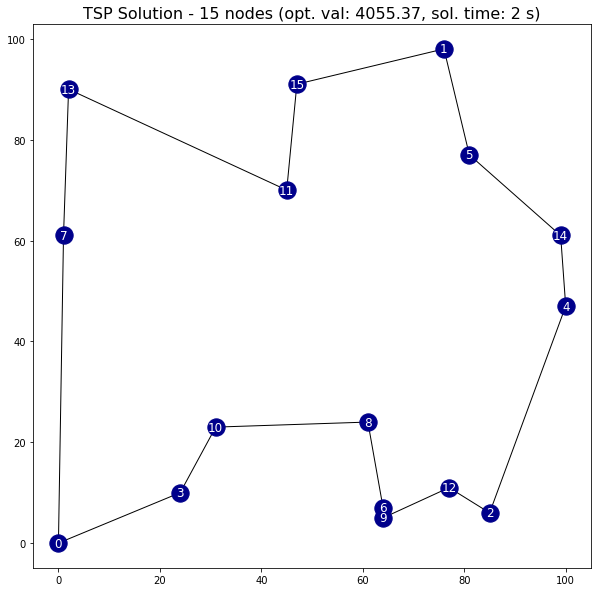

In [23]:
# Add edges to model object
for (u,v) in edge_list:
    G.add_edge(v, u, capacity=1) 

# Create plot object
fig, ax = plt.subplots(figsize=(10,10))

# Draw plot
nx.draw(G, coord, edgelist=edge_list, edge_labels=True, with_labels=True, font_color='w', node_color='darkblue', ax=ax)

# Set limits
limits=plt.axis('on')

# Format ticks
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

# Define optimal value & string for plot title
opt_val = round(cost_optimal, 2)
string = 'TSP Solution - ' + str(N-1) + ' nodes (opt. val: ' + str(opt_val) + ', ' 'sol. time: ' + str(runtime) + ' s)'

# Plot title
ax.set_title(string, fontsize = 16)
plt.show();

# Save figure as .png file
saveas = 'TSPoutput_' + str(N-1) +'nodes_' + today +'.png'
fig.savefig(saveas);

### Save solution as CSV

In [22]:
saveas_csv = 'TSPoutput_' + str(N-1) +'nodes_' + today +'.csv'
solution.to_csv(saveas_csv, index=False)